# Feature Engineering

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요
DATA_PATH = '/data/ephemeral/data/train_data.csv'

df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
df.head()

CPU times: user 3.41 s, sys: 356 ms, total: 3.77 s
Wall time: 3.78 s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


---

## 🔨 도메인 지식 (Domain Knowledge)

### testTag (대분류)
    - A/060/000/001 자리중 가운데 수 를 기준으로  
    - ['1', '2', '3', '4', '5', '6', '7', '8', '9'] : 초등학생 1,2,3,4,5,6, 중학생 1,2,3 (7,8,9)

In [31]:
# 1 ~ 9 카테고리 값

testTag = df['testId'].apply(lambda x: x[2]).unique()
testTag.sort()
testTag

array(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [32]:
df['testTag'] = df['testId'].apply(lambda x: x[2]).astype('int16')
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6


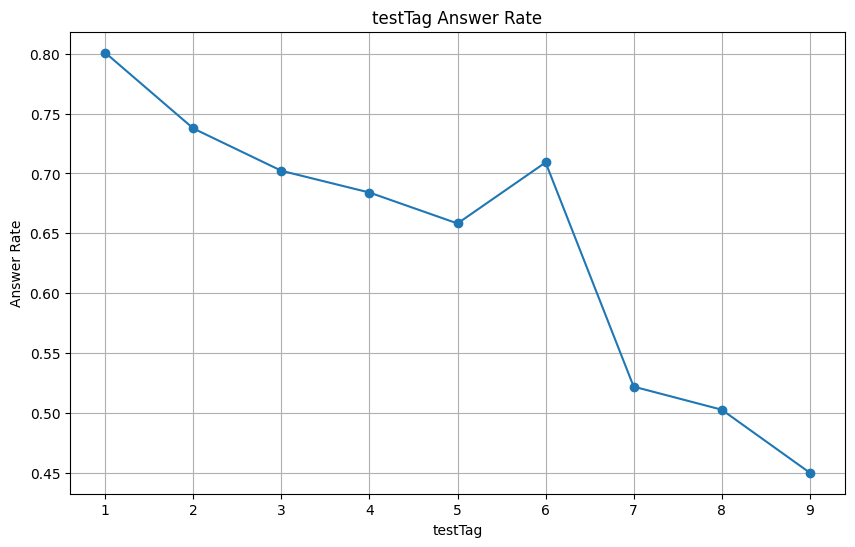

In [33]:
# testTag 별 정답률

def percentile(s):
    return np.sum(s) / len(s)

testTag_group = df.groupby('testTag').agg({
    'answerCode': percentile
})

plt.figure(figsize=(10, 6))
plt.plot(testTag_group.index, testTag_group['answerCode'], marker='o', linestyle='-')
plt.title('testTag Answer Rate')
plt.xlabel('testTag')
plt.ylabel('Answer Rate')
plt.xticks(testTag_group.index)
plt.grid(True)


### 유저 정답 

- `user_correct_answer` : 정답 누적 횟수 (처음부터 현재 바로 이전 시점까지) 과거에 맞춘 문제 수
- `user_total_answer` : 제출 누적 횟수 (정답에 상관없이) 
- `user_acc` : 유저 누적 정답 비율
    - 유저별 첫 문제, user_acc 는 NaN 처리 -> 0.5

In [34]:
def feature_engineering(df):

    # 유저별로 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    # testTag 추가
    df['testTag'] = df['testId'].apply(lambda x: x[2])

    # 유저별로 정답 누적 횟수 계산, 결측치 0
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_correct_answer'].fillna(0, inplace=True)
    
    # 유저별로 제출 누적 횟수 계산
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount() 
    
    # 유저별로 누적 정답률 계산, 결측치 0.75
    df['user_acc'] = df['user_correct_answer'] / df['user_total_answer']
    df['user_acc'].fillna(0.75, inplace=True)
    
    return df

In [35]:
df1 = df.copy()
df1 = feature_engineering(df1)
df1.head(5)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testTag,user_correct_answer,user_total_answer,user_acc
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,0.0,0,0.75
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,1.0,1,1.00
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,2.0,2,1.00
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,3.0,3,1.00
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,4.0,4,1.00


In [36]:
# user_accr가 NaN 인경우, user_total_answer 유니크 확인, 0
# 즉 문제를 푼적이 없는 경우, 첫번째 문제를 푼경우

filtered_df = df1[df1['user_acc'].isna()]
filtered_df['user_total_answer'].unique() 

array([], dtype=int64)

In [37]:
# 유저가 처음 시험지를 받고 문제를 풀때 정답을 맞출 확률 0.75
first_question_answer_ratio = df.groupby(['userID', 'testId'])['answerCode'].agg(lambda x: x.iloc[0]).value_counts(normalize=True)

# 결과 출력
print("시험지 별 유저가 첫번째 문제의 answerCode ratio:")
print(first_question_answer_ratio)

시험지 별 유저가 첫번째 문제의 answerCode ratio:
answerCode
1    0.750994
0    0.249006
Name: proportion, dtype: float64


---

## 🔨 통계량 (Statistics)

- `user_mean` : 유저별 평균 정답률 
- `assessment_mean` : 문항별 평균 정답률
- `test_mean` : testId(시험지) 별 평균 정답률 
- `knowledgeTag_mean` : 태그별 평균 정답률
- `testTag_mean` : testTag별(학년별) 평균 정답률

In [38]:
# 기존 데이터 프레임 생성후, 머지 하는 코드 refactoring

def feature_engineering(df):
    
    # userID별 정답률 추가
    df['user_sum'] = df.groupby('userID')['answerCode'].transform('sum')
    df['user_mean'] = df.groupby('userID')['answerCode'].transform('mean')
    
    # assessmentItemID별 정답률 추가
    df['assessment_sum'] = df.groupby('assessmentItemID')['answerCode'].transform('sum')
    df['assessment_mean'] = df.groupby('assessmentItemID')['answerCode'].transform('mean')
    
    # testId별 정답률 추가
    df['test_sum'] = df.groupby('testId')['answerCode'].transform('sum')
    df['test_mean'] = df.groupby('testId')['answerCode'].transform('mean')
    
    # KnowledgeTag별 정답률 추가
    df['knowledgeTag_sum'] = df.groupby('KnowledgeTag')['answerCode'].transform('sum')
    df['knowledgeTag_mean'] = df.groupby('KnowledgeTag')['answerCode'].transform('mean')
    
    # testTag별 정답률 추가
    df['testTag_sum'] = df.groupby('testTag')['answerCode'].transform('sum')
    df['testTag_mean'] = df.groupby('testTag')['answerCode'].transform('mean')

    return df

In [39]:
df2 = df.copy()
df2 = feature_engineering(df2)
df2.head(3)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testTag,user_sum,user_mean,assessment_sum,assessment_mean,test_sum,test_mean,knowledgeTag_sum,knowledgeTag_mean,testTag_sum,testTag_mean
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,470,0.630872,219,0.982063,1268,0.947683,637,0.955022,187545,0.709232
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,470,0.630872,215,0.964126,1268,0.947683,3040,0.913187,187545,0.709232
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,470,0.630872,203,0.910314,1268,0.947683,3040,0.913187,187545,0.709232


---

## 🔨 상대적 (Relative) feature  

- `relative_answer_assessment`: 
    - 해당 문제의 정답 여부와 해당 문제의 평균 정답률 간의 차이 (값은 -1에서 +1 사이)

<br>

1. 문제를 맞았을 경우 (answerCode == 1)
    - 문제가 쉬울 경우 (assessment_mean : 0.9) 결과는 `0.1` // 남들 다 정답 나도 맞춤
    - 문제가 어려울 경우 (assessment_mean : 0.2) 결과는 `0.8` // 남들 다 틀리는거 , 내가 정답
    
2. 문제를 틀렸을 경우 (answerCode == 0)
    - 문제가 쉬울 경우 (assessment_mean : 0.9) 결과는 `-0.9` //  남들 다 정답, 내가 틀림
    - 문제가 어려울 경우 (assessment_mean : 0.2) 결과는 `-0.2` // 남들 다 틀리는 거, 나도 틀림

- 즉, 유저 단위로 총 평균이 높을수록, 다른 학생들에 비하여, 어려운 문제에 대한 정답 비율이 높다. 학습 수준이 높다고 할수 있다.

- 사용자 단위로 Sequence를 생성

    - userA - - - - 
    - userB - - - - 
    - userD - - - - 

- `level` = mean(`relative_answer_assessment`) (유저 단위) 학습 수준을 간접적으로 나타낼수 있음

In [40]:
def feature_engineering(df):
    
    # 유의미한 상대적 정답률
    df['relative_answer_assessment'] = df['answerCode'] - df.groupby('assessmentItemID')['answerCode'].transform('mean')
    
#     df['testTag'] = df['testId'].apply(lambda x: x[2])
#     df['relative_answer_user'] = df['answerCode'] - df.groupby('userID')['answerCode'].transform('mean')
#     df['relative_answer_test'] = df['answerCode'] - df.groupby('testId')['answerCode'].transform('mean')
#     df['relative_answer_KnowledgeTag'] = df['answerCode'] - df.groupby('KnowledgeTag')['answerCode'].transform('mean')
#     df['relative_answer_testTag'] = df.groupby('testTag')['answerCode'].transform('mean')
    return df

In [41]:
df3 = df.copy()
df3 = feature_engineering(df3)
df3.head(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testTag,relative_answer_assessment
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,0.017937
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,0.035874
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,0.089686
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,0.031390
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,0.058296
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,6,0.080717
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,6,-0.882353
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,6,0.081448
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,6,0.479638
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,6,0.176471


Text(0, 0.5, 'count')

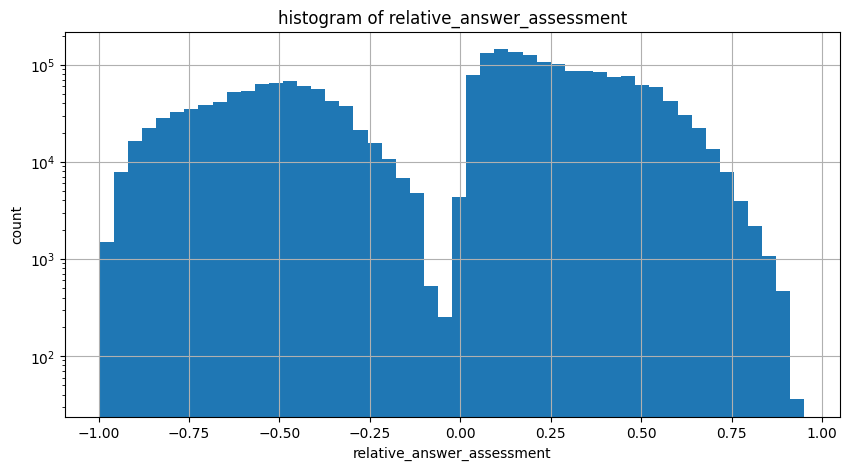

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
df3['relative_answer_assessment'].hist(bins=50)

plt.yscale('log')
plt.grid('False')
plt.title('histogram of relative_answer_assessment')
plt.xlabel('relative_answer_assessment')
plt.ylabel('count')

---

## 🔨 날짜와 시간 (Datetime)

- 유저가 문항을 푸는데 걸린 시간
    - 시퀀스 모델에 넣을 때, 유저별 문항 풀이 평균 속도 <-

In [43]:
#  유저가 문제를 푼 시간 처리, 마지막 문제의 경우 결측치
def feature_engineering(df):
    df['time_to_solve'] = df.groupby(['userID', 'testId'])['Timestamp'].diff().dt.total_seconds().shift(-1)
    return df

In [44]:
df4 = df.copy()
df4 = feature_engineering(df4)
df4.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testTag,time_to_solve
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,11.0


In [45]:
df4[df4['userID']==7440]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testTag,time_to_solve
2266562,7440,A050096001,A050000096,1,2020-08-19 04:57:19,5267,5,45.0
2266563,7440,A050096002,A050000096,0,2020-08-19 04:58:04,10313,5,13.0
2266564,7440,A050096005,A050000096,0,2020-08-19 04:58:17,5267,5,10.0
2266565,7440,A050096004,A050000096,1,2020-08-19 04:58:27,5267,5,25.0
2266566,7440,A050096003,A050000096,0,2020-08-19 04:58:52,10328,5,NaN
2266567,7440,A030136001,A030000136,1,2020-09-23 09:19:35,7691,3,47.0
2266568,7440,A030136002,A030000136,1,2020-09-23 09:20:22,7690,3,76.0
2266569,7440,A030136003,A030000136,1,2020-09-23 09:21:38,7691,3,5.0
2266570,7440,A030136004,A030000136,0,2020-09-23 09:21:43,7691,3,10.0
2266571,7440,A030136005,A030000136,0,2020-09-23 09:21:53,7691,3,NaN


---

## 🔨  과거 (prior) feature

In [46]:
def feature_engineering(df):
    
    df['testTag'] = df['testId'].apply(lambda x: x[2]).astype('int16')

    # clip(0, 255)는 메모리를 위해 uint8 데이터 타입을 쓰기 위함
    df['prior_assessment_frequency'] = df.groupby(['userID', 'assessmentItemID']).cumcount().clip(0, 255)

    # 각 태그별로 이전에 몇번 풀었는지
    df['prior_KnowledgeTag_frequency'] = df.groupby(['userID', 'KnowledgeTag']).cumcount()
    
    # 시험지 태그별 학년별 몇번 풀었는지
    df['prior_testTag_frequency'] = df.groupby(['userID', 'testTag']).cumcount()

    
    return df

In [47]:
df5 = df.copy()
df5 = feature_engineering(df5)
df5.head(5)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testTag,prior_assessment_frequency,prior_KnowledgeTag_frequency,prior_testTag_frequency
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,0,0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,0,1,2
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,0,2,3
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,0,3,4


---

## 데이터 타입 변경 포함

In [48]:
import pandas as pd

def feature_engineering(df):

    # 유저별로 정렬
    df.sort_values(by=['userID', 'Timestamp'], inplace=True)
    
    # 데이터 타입 변경
    dtype = {
        'userID': 'int16',
        'answerCode': 'int8',
        'KnowledgeTag': 'int16'
    }
    df = df.astype(dtype)
    
    # 'Timestamp' 열을 날짜/시간 형식으로 파싱
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')

    # testTag 추가
    df['testTag'] = df['testId'].apply(lambda x: x[2]).astype('int16')

    # 유저별로 정답 누적 횟수 계산, 결측치 0
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_correct_answer'].fillna(0, inplace=True)
    
    # 유저별로 제출 누적 횟수 계산
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount() 
    
    # 유저별로 누적 정답률 계산, 결측치 0.75
    df['user_acc'] = df['user_correct_answer'] / df['user_total_answer']
    df['user_acc'].fillna(0.75, inplace=True)

    # userID별 정답률 추가
    df['user_sum'] = df.groupby('userID')['answerCode'].transform('sum')
    df['user_mean'] = df.groupby('userID')['answerCode'].transform('mean')
    
    # assessmentItemID별 정답률 추가
    df['assessment_sum'] = df.groupby('assessmentItemID')['answerCode'].transform('sum')
    df['assessment_mean'] = df.groupby('assessmentItemID')['answerCode'].transform('mean')
    
    # testId별 정답률 추가
    df['test_sum'] = df.groupby('testId')['answerCode'].transform('sum')
    df['test_mean'] = df.groupby('testId')['answerCode'].transform('mean')
    
    # KnowledgeTag별 정답률 추가
    df['knowledgeTag_sum'] = df.groupby('KnowledgeTag')['answerCode'].transform('sum')
    df['knowledgeTag_mean'] = df.groupby('KnowledgeTag')['answerCode'].transform('mean')
    
    # testTag별 정답률 추가
    df['testTag_sum'] = df.groupby('testTag')['answerCode'].transform('sum')
    df['testTag_mean'] = df.groupby('testTag')['answerCode'].transform('mean')

    # 상대적 정답률
    df['relative_answer_assessment'] = df['answerCode'] - df.groupby('assessmentItemID')['answerCode'].transform('mean')

    # 유저가 문항을 푼 시간
    df['time_to_solve'] = df.groupby(['userID', 'testId'])['Timestamp'].diff().dt.total_seconds().shift(-1)

    # clip(0, 255)는 메모리를 위해 uint8 데이터 타입을 쓰기 위함
    df['prior_assessment_frequency'] = df.groupby(['userID', 'assessmentItemID']).cumcount().clip(0, 255)

    # 각 태그별로 이전에 몇번 풀었는지
    df['prior_KnowledgeTag_frequency'] = df.groupby(['userID', 'KnowledgeTag']).cumcount()
    
    # 시험지 태그별 학년별 몇번 풀었는지
    df['prior_testTag_frequency'] = df.groupby(['userID', 'testTag']).cumcount()
    
    return df


In [49]:
df6 = df.copy()
df6 = feature_engineering(df6)
df6.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testTag,user_correct_answer,user_total_answer,user_acc,...,test_mean,knowledgeTag_sum,knowledgeTag_mean,testTag_sum,testTag_mean,relative_answer_assessment,time_to_solve,prior_assessment_frequency,prior_KnowledgeTag_frequency,prior_testTag_frequency
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,0.0,0,0.75,...,0.947683,637,0.955022,187545,0.709232,0.017937,3.0,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,1.0,1,1.00,...,0.947683,3040,0.913187,187545,0.709232,0.035874,8.0,0,0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,2.0,2,1.00,...,0.947683,3040,0.913187,187545,0.709232,0.089686,7.0,0,1,2
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,3.0,3,1.00,...,0.947683,3040,0.913187,187545,0.709232,0.031390,7.0,0,2,3
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,4.0,4,1.00,...,0.947683,3040,0.913187,187545,0.709232,0.058296,11.0,0,3,4
